# codes to measure qubit frequency vs gate

In [36]:

# packages needed
import os
import Labber
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from dataanalyzer import Plotter, Fitter, fitmodels, load_labber_file, Valueclass
import quantum_fitter as qf
from scipy.signal import find_peaks
from BaselineRemoval import BaselineRemoval

plt.style.use("presentation.mplstyle")

In [37]:
import  json

# Labber API measuremts

In [38]:
import Labber
clinet = Labber.connectToServer('localhost', timeout=None)

### unit

In [39]:
MHz, GHz = 1e6, 1e9
ns, us = 1e-9, 1e-6

### template

In [40]:
template = r"C:\Users\T2-1\Dropbox\My PC (T2-1)\Desktop\Zhenhai\data_processing\generalCode\NW3_spec.hdf5"

### function to check the file names in the path and produce one new name

In [41]:
def uniquify(path) -> str:
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = f"{filename}_{str(counter)}{extension}"
        counter += 1

    return path

### resonator scan

In [42]:
def readout_freq(msmt_template=template, center=6.0*GHz, span=5.0*MHz, power=-40.0, **kwargs):
    """take the center and span[Hz] and npt to sweep the readout resonator, return the minima of the S21"""

    path_temp = uniquify(path="20230706_Chip7_chargePhase/NW3_res.hdf5")

    # default settings if nothing is set when call the function
    pump = kwargs["pump"] if "pump" in kwargs else True
    npt = kwargs["npt"] if "npt" in kwargs else 101
    detuning = kwargs["detuning"] if "detuning" in kwargs else 0.2*MHz
    gate = kwargs["gate"] if "gate" in kwargs else None
    updateKeith = kwargs["updateKeith"] if "updateKeith" in kwargs else False

    rs_msmt = Labber.ScriptTools.MeasurementObject(msmt_template, path_temp)
    rs_msmt.updateValue(channel_name="Readout - Frequency", value=center, itemType='center')
    rs_msmt.updateValue(channel_name="Readout - Frequency", value=span, itemType='span')
    rs_msmt.updateValue(channel_name="Readout - Power", value=power, itemType='SINGLE')
    rs_msmt.updateValue(channel_name="Readout - Frequency", value=npt, itemType='n_pts')
    rs_msmt.updateValue(channel_name="Readout - Output", value=1, itemType='SINGLE')
    rs_msmt.updateValue(channel_name="Drive - Frequency", value=0, itemType='SINGLE')
    rs_msmt.updateValue(channel_name="Drive - Output", value=0, itemType='SINGLE')
    rs_msmt.updateValue(channel_name="Digitizer - Number of averages", value=1000, itemType='SINGLE')

    if not pump:
        rs_msmt.updateValue(channel_name="Pump - Output", value=0, itemType='SINGLE')
        rs_msmt.updateValue(channel_name="Digitizer - Number of averages", value=3000, itemType='SINGLE')
    if gate is not None:
        if updateKeith is True:
            keith = clinet.connectToInstrument('Keithley 2400 SourceMeter', dict(interface='GPIB', address='07'))
            keith.setValue('Source voltage', gate, rate=0.02)
            time.sleep(120)
        rs_msmt.updateValue(channel_name="Keithley - Source voltage", value=gate, itemType='SINGLE')
    rs_S21 = rs_msmt.performMeasurement(return_data=False)
    [freq], [S21] = load_labber_file(rs_S21, inspect=False)
    rs_freq = freq[S21.abs.argmin()].value
    read_freq = freq[S21.abs.argmin()].value + detuning

    return rs_freq[0], read_freq[0], S21, freq



In [12]:
rs_freq, read_freq, S21, _ = readout_freq(msmt_template=template, span=25*MHz, center=6.42*GHz, gate=0.0, power=-50.0, updateKeith=False, pump=True)
print("readout freq is {}".format(read_freq))

readout freq is 6410100000.0


### qubit specotroscopy vs gate 2D scan

#### qubit spec @ single gate voltage

In [43]:
# def qubit_spectroscopy(msmt_template=template_nowait, readout_power=-40, readout_freq=6*GHz, center=4.0*GHz, span=300.0*MHz, step=1.0*MHz, power=-40, gate=None, updateKeith=False):
def qubit_spectroscopy(msmt_template=template, center=4.0*GHz, span=300.0*MHz, drive_power=-40,  readout_freq=6*GHz, **kwargs):
    """sweep drive frequency and take the peak as a qubit frequency"""

    path_temp = uniquify("20230706_Chip7_chargePhase/NW3_spec.hdf5")

    # default settings if nothing is set when call the function
    pump = kwargs["pump"] if "pump" in kwargs else True
    readout_power = kwargs["readout_power"] if "readout_power" in kwargs else -50.0
    npt = kwargs["npt"] if "npt" in kwargs else 101
    gate = kwargs["gate"] if "gate" in kwargs else None
    updateKeith = kwargs["updateKeith"] if "updateKeith" in kwargs else False

    spec_msmt = Labber.ScriptTools.MeasurementObject(msmt_template, path_temp)
    spec_msmt.updateValue(channel_name="Readout - Frequency", value=readout_freq, itemType='SINGLE')
    spec_msmt.updateValue(channel_name="Readout - Power", value=readout_power, itemType='SINGLE')
    spec_msmt.updateValue(channel_name="Readout - Output", value=1, itemType='SINGLE')
    spec_msmt.updateValue(channel_name="Drive - Frequency", value=center, itemType='center')
    spec_msmt.updateValue(channel_name="Drive - Frequency", value=span, itemType='span')
    spec_msmt.updateValue(channel_name="Drive - Frequency", value=npt, itemType='n_pts')
    spec_msmt.updateValue(channel_name="Drive - Power", value=drive_power, itemType='SINGLE')
    spec_msmt.updateValue(channel_name="Drive - Output", value=1, itemType='SINGLE')
    spec_msmt.updateValue(channel_name="Digitizer - Number of averages", value=1000, itemType='SINGLE')
    if not pump:
        spec_msmt.updateValue(channel_name="Pump - Output", value=0, itemType='SINGLE')
        spec_msmt.updateValue(channel_name="Digitizer - Number of averages", value=2000, itemType='SINGLE')
    

    if gate is not None:
        if updateKeith is True:
            keith = clinet.connectToInstrument('Keithley 2400 SourceMeter', dict(interface='GPIB', address='07'))
            keith.setValue('Source voltage', gate, rate=0.02)
            time.sleep(2)
        spec_msmt.updateValue(channel_name="Keithley - Source voltage", value=gate, itemType='SINGLE')

    qubit_spec = spec_msmt.performMeasurement(return_data=False)
    [freq], [spec] = load_labber_file(qubit_spec, inspect=True)
   

    return spec, freq
    



In [46]:
def qubitSpecGateScan(start=0.0, stop=-1.0, step=0.01, res_npt=101, qubit_npt=601):

    gate_array = Valueclass(name="gate", unit="V", value=np.arange(start, stop, step))
    S21_2D_value = np.zeros((np.shape(gate_array)[0], res_npt))
    qubit_spec_2D_value = np.zeros((np.shape(gate_array)[0], qubit_npt))

    for i, gate_i in enumerate(gate_array.value):
        print("the voltage is {}".format(gate_i))
        keith = clinet.connectToInstrument('Keithley 2400 SourceMeter', dict(interface='GPIB', address='07'))
        keith.setValue('Source voltage', gate_i, rate=0.02)
        time.sleep(1)
        rs_freq, read_freq, S21, resfreq = readout_freq(span=10*MHz, center=6.481*GHz, gate=gate_i, power=-45.0, npt=res_npt)
        S21_2D_value[i, :] = S21.abs.db.value
        spec, qubitfreq = qubit_spectroscopy(readout_freq=read_freq, center=4.5*GHz, span=2000.0*MHz, drive_power=-25.0, gate=gate_i, npt=qubit_npt)
        qubit_spec_2D_value[i, :] = spec.abs.db.value - spec.abs.db.value.mean()
        
    S21_2D = Valueclass(name="S21", unit="dB", value=S21_2D_value)
    qubit_spec_2D = Valueclass(name="spec", unit="dB", value=qubit_spec_2D_value)

    plot = Plotter((2, 1))
    plot.heatmap(x=resfreq, y=gate_array, Z=S21_2D)

    plot.heatmap(x=qubitfreq, y=gate_array, Z=qubit_spec_2D, ax=1)
    plot.show()

    plot.save("qubit_spec_gate_scan_NW5.pdf")

    # To save data:
    with open('gate_array_5.json', 'w') as fp:
        json.dump(gate_array.todict(), fp)
    with open('qubit_spec_5.json', 'w') as fp:
        json.dump(qubit_spec_2D.todict(), fp)

    return gate_array, S21_2D, qubit_spec_2D

        

the voltage is 0.0
inspecting Labber File...
File is containing 1 parameters:
	Drive - Frequency
File is containing 1 results:
	Multi-Qubit Pulse Generator - Voltage, QB1
the voltage is -0.02
inspecting Labber File...
File is containing 1 parameters:
	Drive - Frequency
File is containing 1 results:
	Multi-Qubit Pulse Generator - Voltage, QB1
the voltage is -0.04
inspecting Labber File...
File is containing 1 parameters:
	Drive - Frequency
File is containing 1 results:
	Multi-Qubit Pulse Generator - Voltage, QB1
the voltage is -0.06
inspecting Labber File...
File is containing 1 parameters:
	Drive - Frequency
File is containing 1 results:
	Multi-Qubit Pulse Generator - Voltage, QB1
the voltage is -0.08
inspecting Labber File...
File is containing 1 parameters:
	Drive - Frequency
File is containing 1 results:
	Multi-Qubit Pulse Generator - Voltage, QB1


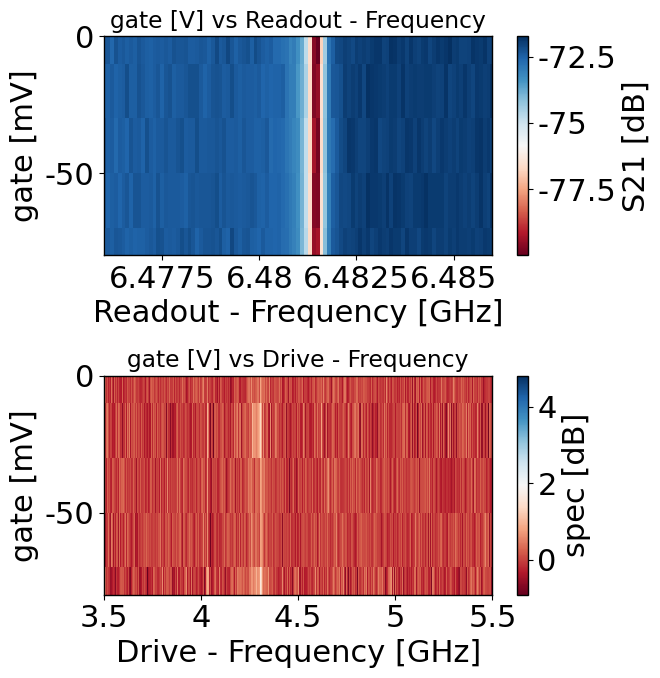

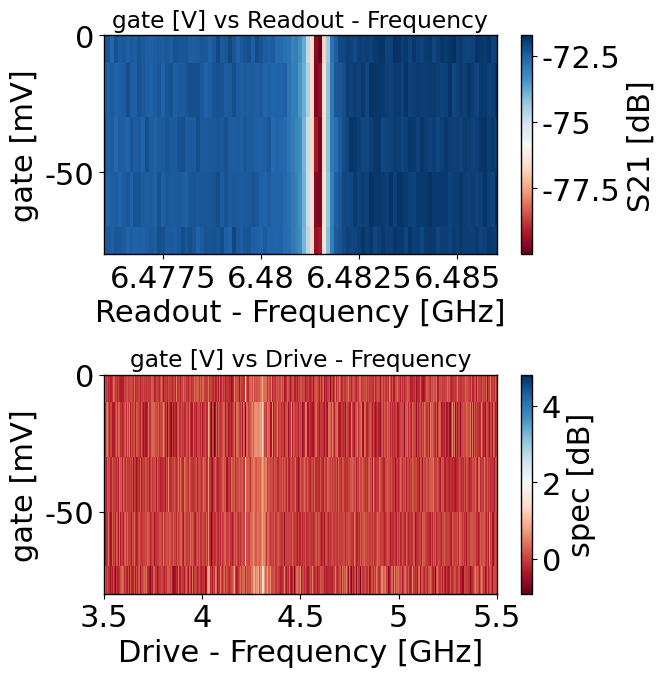

In [47]:
gate, s21, qubit_spec_2D = qubitSpecGateScan(start=0, stop=-0.1, step=-0.02)

In [207]:
keith = clinet.connectToInstrument('Keithley 2400 SourceMeter', dict(interface='GPIB', address='07'))
keith.setValue('Source voltage', 0, rate=0.02)

0.0